In [137]:
import pandas as pd
import json
import os
from pathlib import Path
import numpy as np

PATH = Path("evaluation_results-seeds")

data = []
for file in PATH.glob('*.json'):
    with open(file) as f:
        try:
            j = json.load(f)
        except:
            print(file)
            continue

    concept, method, seed, _, iteration, _ = str(file.stem).split('-')
    outdict = {
        'concept': concept,
        'method': method,
        'seed': seed,
        'iteration': int(iteration)
    }
    outdict["CLIP-T"] = j["CLIP-T"]
    outdict["CLIP-I"] = j["CLIP-I"]
    outdict["DINO"] = j['DINO']
    outdict["DIV"] = j['DIV']
    data.append(outdict)
data.sort(key=lambda x: (x['concept'], x['method'], x['seed'], x['iteration']))

df = pd.DataFrame(data)
df   

,concept,method,seed,iteration,CLIP-T,CLIP-I,DINO,DIV
0,backpack_dog,disenbooth,1,200,0.349583,0.615158,0.311782,0.669735
1,backpack_dog,disenbooth,1,400,0.350034,0.620219,0.364336,0.643138
2,backpack_dog,disenbooth,1,600,0.346797,0.625556,0.397180,0.626572
3,backpack_dog,disenbooth,1,800,0.346565,0.643374,0.436114,0.607873
4,backpack_dog,disenbooth,1,1000,0.346724,0.652624,0.475334,0.600211
...,...,...,...,...,...,...,...,...
355,dog,mydisenbooth,3,2200,0.313286,0.829910,0.760044,0.612449
356,dog,mydisenbooth,3,2400,0.314055,0.831383,0.758676,0.624633
357,dog,mydisenbooth,3,2600,0.311313,0.830100,0.766521,0.620745
358,dog,mydisenbooth,3,2800,0.309468,0.828601,0.761287,0.611865


In [138]:
# RECHECK maybe
visresemblance_start = {
    'dreambooth': {
        'can': 400,
        'dog': 400,
        'backpack_dog': 400,
    },
    'disenbooth': {
        'can': 1000,
        'dog': 800, # 1000?
        'backpack_dog': 1200,
    },
    'mydisenbooth': {
        'can': 1000,
        'dog': 800, # 1000?
        'backpack_dog': 1200,
    }
}

# RECHECK
optimal_checkpoints = {
    'dreambooth': {
        'can': 800,
        'dog': 600,
        'backpack_dog': 800,
    },
    'disenbooth': {
        'can': 2000, # 1800?
        'dog': 1200, 
        'backpack_dog': 1800, # 1800?
    },
    'mydisenbooth': {
        'can': 2000,
        'dog': 1200,
        'backpack_dog': 1800, # 1800?
    }
}

In [142]:
optimal_df = []
for method in optimal_checkpoints:
    for concept in optimal_checkpoints[method]:
        optimal_df.append(df[(df["method"] == method) & (df["concept"] == concept) & (df['iteration'] == optimal_checkpoints[method][concept])])
optimal_df = pd.concat(optimal_df)
optimal_df[["concept", "method", "CLIP-T", "DINO", "DIV", "CLIP-I"]].groupby(["concept", "method"]).mean()

CLIP-T      DINO       DIV    CLIP-I
concept      method                                              
backpack_dog disenbooth    0.341768  0.546136  0.574358  0.697410
             dreambooth    0.337279  0.535059  0.564754  0.686178
             mydisenbooth  0.341475  0.529446  0.572084  0.682424
can          disenbooth    0.316472  0.713528  0.518920  0.721851
             dreambooth    0.309545  0.702072  0.544600  0.738891
             mydisenbooth  0.313013  0.716577  0.525283  0.717278
dog          disenbooth    0.328809  0.743090  0.639542  0.824765
             dreambooth    0.330964  0.667934  0.614176  0.812705
             mydisenbooth  0.326743  0.734666  0.641261  0.820307

CLIP-T


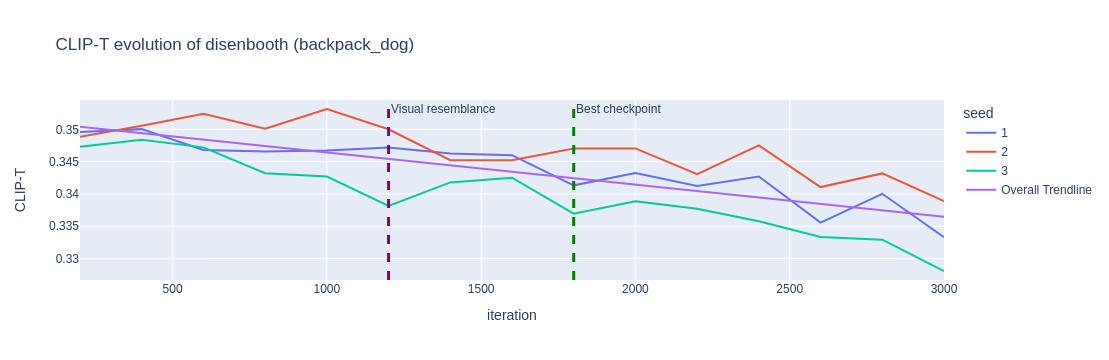

In [134]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go


def make_metric_evolution_plot(method='dreambooth', concept='can', metric='CLIP-T'):
    subdf = df[df['method'] == method]
    subdf = subdf[subdf['concept'] == concept]
    title = f'{metric} evolution of {method} ({concept})'
    print(metric)
    fig = px.scatter(subdf, x="iteration", y=metric, title=title, color='seed' , trendline="ols", trendline_scope='overall')

    fig.update_traces(mode = 'lines')
    fig.add_vline(x=visresemblance_start[method][concept], line_width=3, line_dash="dash", line_color="purple", annotation_text="Visual resemblance")
    fig.add_vline(x=optimal_checkpoints[method][concept], line_width=3, line_dash="dash", line_color="green", annotation_text="Best checkpoint")
    ##fig.update_layout(showlegend=True)
    
    fig.update_yaxes(nticks=10)
    # fig.update_xaxes(nticks=10)
    return fig

method = 'disenbooth'
concept = 'backpack_dog'
fig = make_metric_evolution_plot(method, concept, 'CLIP-T')
'''
fig = make_subplots(rows=3, cols=1)
print(type(fig))
for i, metric in enumerate(['CLIP-T', 'DINO', 'DIV']):
    traces = make_metric_evolution_plot('dreambooth', 'can', metric)
    for trace in range(len(traces["data"])):
        print(trace, i)
        fig.append_trace(traces["data"][trace], row=i + 1, col=1)
'''
fig.show()

DINO


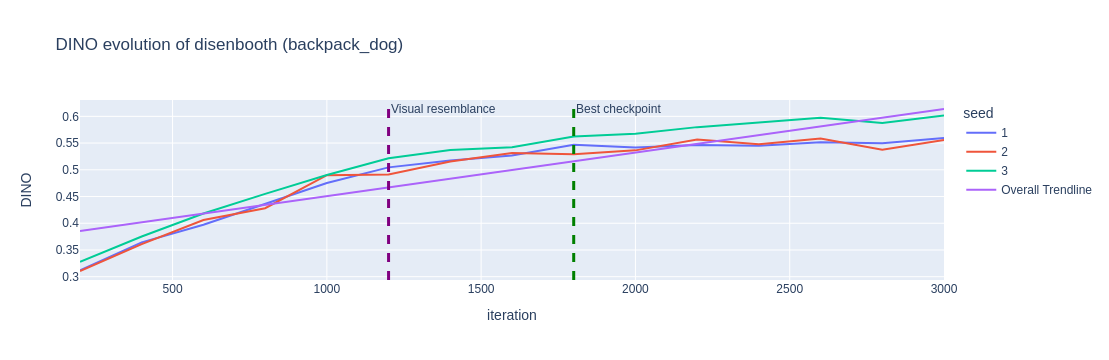

In [135]:
make_metric_evolution_plot(method, concept, 'DINO').show()

DIV


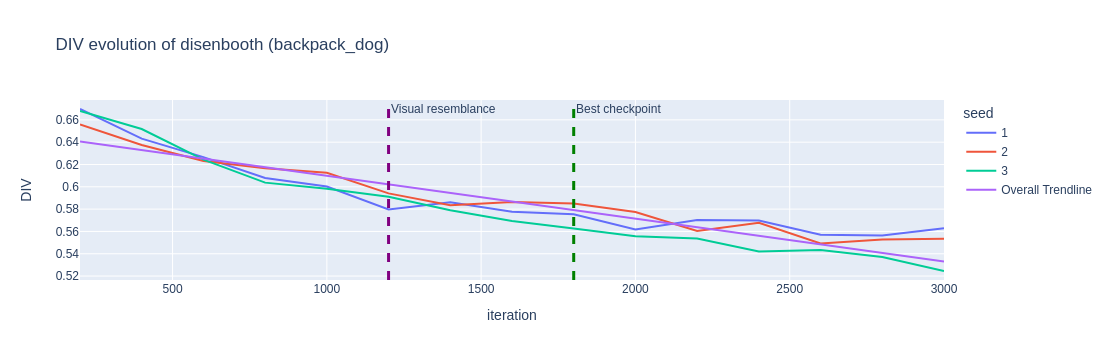

In [136]:
make_metric_evolution_plot(method, concept, 'DIV').show()

In [68]:
def get_mean_curve(curves):
    curves = np.array(curves)
    mean_curve = curves.mean(axis=0)
    return mean_curve    

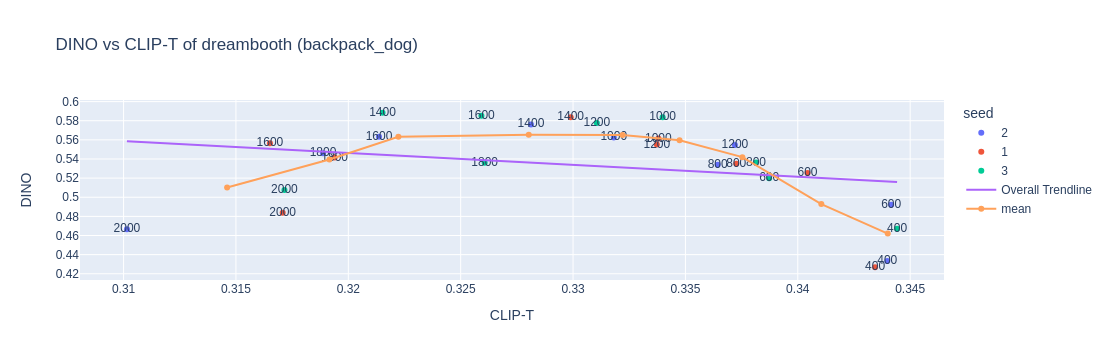

In [108]:
def make_versus_plot(method='dreambooth', concept='can', metric1='DINO', metric2='CLIP-T', exclude_early=False):
    assert(metric1 != metric2)
    subdf = df[df['method'] == method]
    subdf = subdf[subdf['concept'] == concept].copy()
    if exclude_early:
        subdf = subdf[subdf['iteration'] >= visresemblance_start[method][concept]]
    subdf = subdf.sort_values([metric2, metric1])
    title = f'{metric1} vs {metric2} of {method} ({concept})'
    fig = px.scatter(subdf, x=metric2, y=metric1, 
                     text=subdf['iteration'].astype(str),
                     title=title, color='seed', trendline="ols", trendline_scope='overall')
    mean_curve = get_mean_curve([subdf[subdf['seed'] == seed][[metric1, metric2]].values for seed in subdf.seed])
    fig.add_scatter(x=mean_curve[:, 1], y=mean_curve[:, 0], mode='lines+markers', name='mean',
                    showlegend=True) #  annotation_text='',
    fig.update_yaxes(nticks=10)
    fig.update_xaxes(nticks=10)

    # fig.update_traces(mode = 'lines')
    ##fig.update_layout(showlegend=True)
    return fig
make_versus_plot(method, concept, 'DINO', exclude_early=True).show()

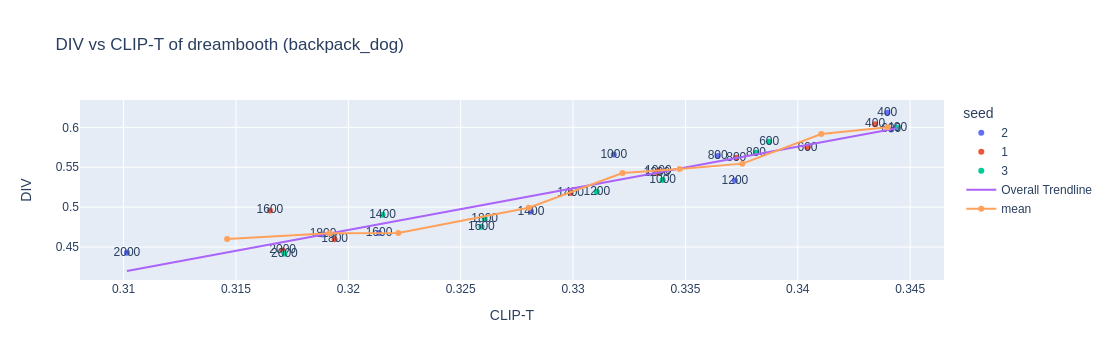

In [70]:
make_versus_plot(method, concept, 'DIV', exclude_early=True).show()

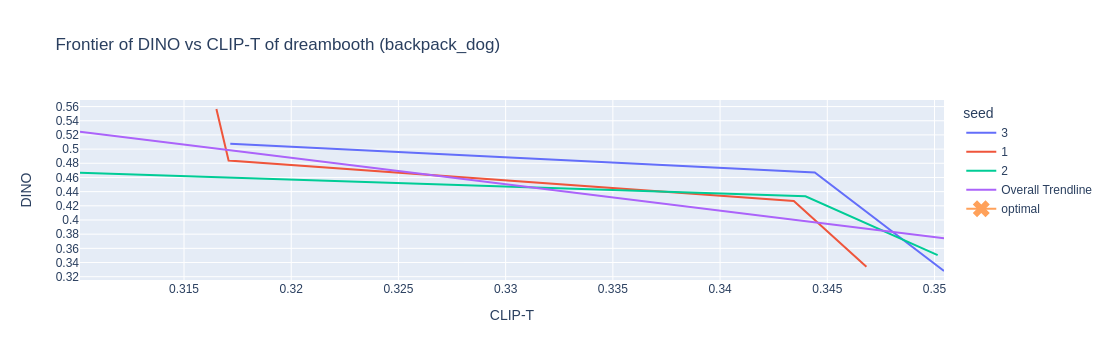

In [75]:
import numpy as np
from scipy.spatial import ConvexHull

def is_pareto_efficient_simple(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient][:, :2]<c[:2], axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

def select_efficient_frontier(run, metric1, metric2):
    mask = is_pareto_efficient_simple(run[[metric1, metric2]].values)
    return run[mask]


def make_pareto_plot(method='dreambooth', concept='can', metric1='DINO', metric2='CLIP-T', exclude_early=False):
    assert(metric1 != metric2)
    subdf = df[df['method'] == method]
    subdf = subdf[subdf['concept'] == concept].copy()
    if exclude_early:
        subdf = subdf[subdf['iteration'] >= visresemblance_start[method][concept]]
    subdf = subdf.sort_values([metric1, metric2])

    total_mask = np.ones(len(subdf))
    subarrays = []
    for seed in set(subdf.seed):
        subarrays.append(select_efficient_frontier(subdf[subdf['seed'] == seed], metric1, metric2))
    subdf = pd.concat(subarrays)
    optimal_solution = subdf[subdf['iteration'] == optimal_checkpoints[method][concept]]
    #ch = ConvexHull(arr, qhull_options='QG1')
    #subdf = subdf[ch.good]
    title = f'Frontier of {metric1} vs {metric2} of {method} ({concept})'
    fig = px.scatter(subdf, x=metric2, y=metric1, 
                     text=subdf['iteration'].astype(str),
                     title=title, color='seed', trendline="ols", trendline_scope='overall')
    fig.update_traces(mode = 'lines')
    fig.add_scatter(x=[optimal_solution[metric2].median()],
                y=[optimal_solution[metric1].median()],
                marker_symbol='x', marker_size=15,
               name='optimal')
    fig.update_yaxes(nticks=15)
    fig.update_xaxes(nticks=15)

    return fig
make_pareto_plot(method, concept, 'DINO').show()

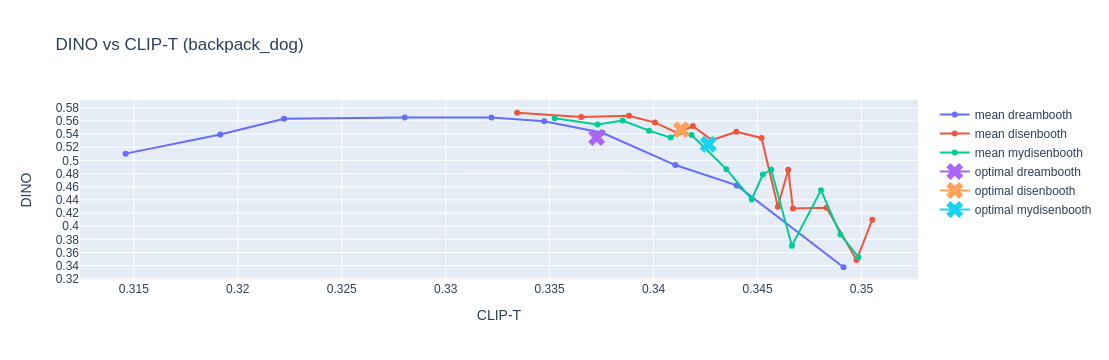

In [120]:
def make_super_versus_plot(concept='can', methods=['dreambooth', 'disenbooth', 'mydisenbooth'],
                          metric1='DINO', metric2='CLIP-T', exclude_early=False):
    curves = []
    exclude_early = False
    title = f'{metric1} vs {metric2} ({concept})'
    for method in methods:
        subdf = df[df['method'] == method]
        subdf = subdf[subdf['concept'] == concept].copy()
        if exclude_early:
            subdf = subdf[subdf['iteration'] >= visresemblance_start[method][concept]]
        subdf = subdf.sort_values([metric2, metric1])
        curves.append(get_mean_curve([subdf[subdf['seed'] == seed][[metric1, metric2]].values for seed in subdf.seed]))
    fig = px.scatter(x=curves[0][:, 1], y=curves[0][:, 0], title=title,
                    labels={
                         "x": metric2,
                         "y": metric1,
                     },
    ) #   name='mean ' + methods[0]
    fig.data[-1].showlegend = True
    
    fig.update_traces(mode = 'lines+markers', name='mean ' + methods[0])
    for i in range(1, len(curves)):
         fig.add_scatter(x=curves[i][:, 1], y=curves[i][:, 0], mode='lines+markers', name='mean ' + methods[i],
                    showlegend=True)
    for method in methods:
        subdf = df[df['method'] == method]
        subdf = subdf[subdf['concept'] == concept].copy()
        if exclude_early:
            subdf = subdf[subdf['iteration'] >= visresemblance_start[method][concept]]
        subdf = subdf.sort_values([metric2, metric1])
        optimal_solution = subdf[subdf['iteration'] == optimal_checkpoints[method][concept]]
        fig.add_scatter(x=[optimal_solution[metric2].median()],
                y=[optimal_solution[metric1].median()],
                marker_symbol='x', marker_size=15,
               name='optimal ' + method)
    fig.update_yaxes(nticks=15)
    fig.update_xaxes(nticks=20)
    return fig
make_super_versus_plot(concept='backpack_dog').show()

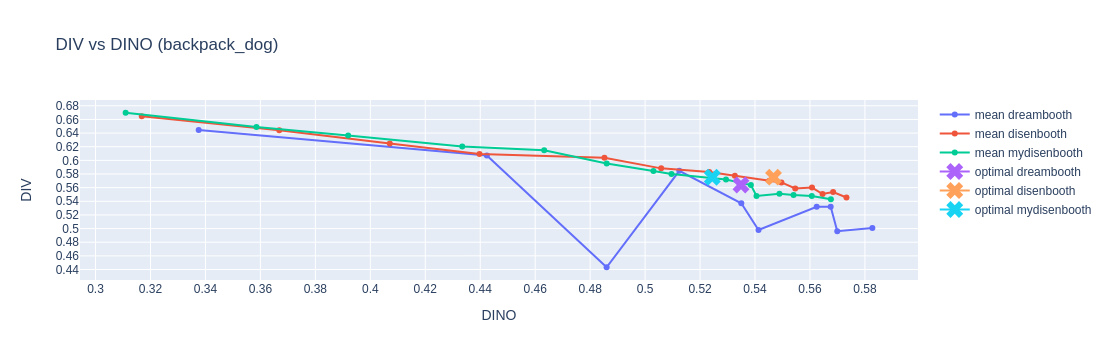

In [126]:
make_super_versus_plot(concept='backpack_dog', metric1='DIV', metric2='DINO').show()

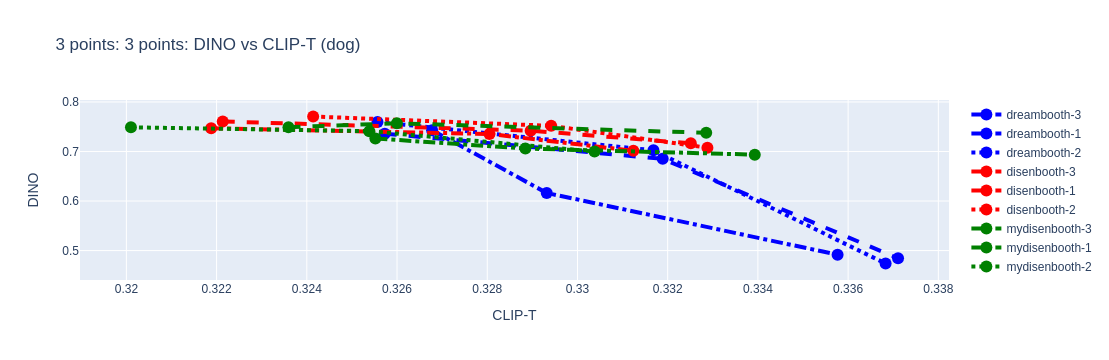

In [112]:
import plotly.graph_objects as go


def make_3point_versus_plot(concept='can', methods=['dreambooth', 'disenbooth', 'mydisenbooth'],
                          metric1='DINO', metric2='CLIP-T', exclude_early=False):
    curves = []
    exclude_early = False
    title = f'3 points: {metric1} vs {metric2} ({concept})'
    df4concat = []
    fig = go.Figure()
    colors = ['blue', 'red', 'green', 'purple', 'yellow', 'pink']

    for i, method in enumerate(methods):
        subdf = df[df['method'] == method]
        subdf = subdf[subdf['concept'] == concept].copy()
        subdf = subdf.sort_values([metric2, metric1])
        opt = optimal_checkpoints[method][concept]
        subdf = subdf[(subdf['iteration'] == opt) | (subdf['iteration'] == opt - 400) | (subdf['iteration'] == opt + 400)]
        for seed in set(subdf.seed):
            s = subdf[subdf['seed'] == seed]
            fig.add_trace(go.Scatter(x=s[metric2], y=s[metric1], name=f'{method}-{seed}',
                          text=s['iteration'].astype(str),
                         mode='lines+markers',
                         marker=dict(size=12),
                         line=dict(color=colors[i], width=4, dash=['dash', 'dot', 'dashdot'][int(seed) - 1])))
    fig.update_layout(title='3 points: ' + title,
                   xaxis_title=metric2,
                   yaxis_title=metric1)
    # fig.update_traces(marker=dict(size=12))

    return fig
make_3point_versus_plot(concept='dog').show()

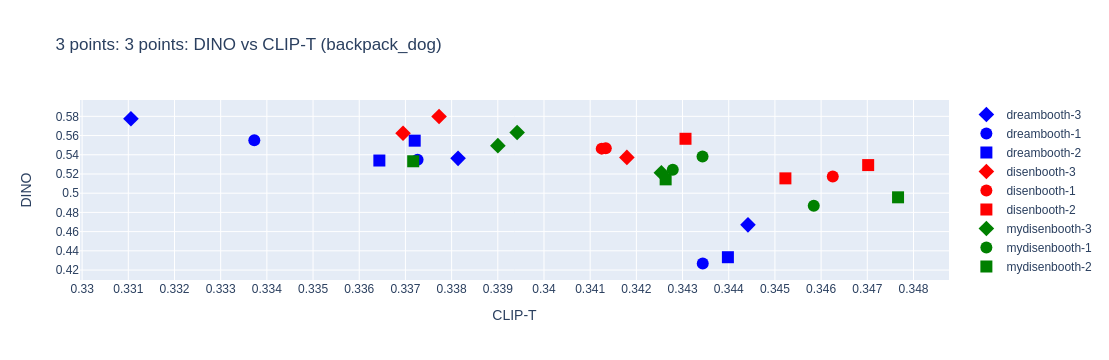

In [147]:
import plotly.graph_objects as go


def make_3point_versus_plot(concept='can', methods=['dreambooth', 'disenbooth', 'mydisenbooth'],
                          metric1='DINO', metric2='CLIP-T', exclude_early=False):
    curves = []
    exclude_early = False
    title = f'3 points: {metric1} vs {metric2} ({concept})'
    df4concat = []
    fig = go.Figure()
    colors = ['blue', 'red', 'green', 'purple', 'yellow', 'pink']

    for i, method in enumerate(methods):
        subdf = df[df['method'] == method]
        subdf = subdf[subdf['concept'] == concept].copy()
        subdf = subdf.sort_values([metric2, metric1])
        opt = optimal_checkpoints[method][concept]
        subdf = subdf[(subdf['iteration'] == opt) | (subdf['iteration'] == opt - 400) | (subdf['iteration'] == opt + 400)]
        for seed in set(subdf.seed):
            s = subdf[subdf['seed'] == seed]
            fig.add_trace(go.Scatter(x=s[metric2], y=s[metric1], name=f'{method}-{seed}',
                          text=s['iteration'].astype(str),
                         mode='markers',
                         marker=dict(size=12, symbol=int(seed) - 1),
                         line=dict(color=colors[i], width=4, dash=['dash', 'dot', 'dashdot'][int(seed) - 1])))
    fig.update_layout(title='3 points: ' + title,
                   xaxis_title=metric2,
                   yaxis_title=metric1)
    fig.update_yaxes(nticks=15)
    fig.update_xaxes(nticks=20)
    # fig.update_traces(marker=dict(size=12))

    return fig
make_3point_versus_plot(concept='backpack_dog').show()